## Simulating  Active Brownian motion
In this notebook, we simulate the trajectory of a single, non-interacting active Brownian particle. Unlike passive Brownian particles (e.g. pollen grains in water) that do diffusive random walks, active Brownian particles (ABPs) propel themselves with directed motion in addition to diffusing randomly. 

The APB model can be used to accurately desribe the motion of certain types of cells, those which locomote actively using focal adhesions. The distribution of focal adhesions within a cell may vary continuously, tending to reorient the cell with respect to it's past momentum and giving rise to different speeds with which the cell moves. It is this angular reorientation which can be modelled as a diffusive process.

Durotaxis is the preference for cells to move preferentially towards a stiffer substrate. In this project we implement durotaxis by incorporating the dependence of a cell's rotational diffusion properties on the stiffness of the medium upon which a cell is crawling.

*It should be noted that although all of the simulations in this project display the trajectories or data associated with numerous cells, intercellular interactions are not taken into account here. This is a simple single cell model.*

In [ ]:
import argparse

parser = argparse.ArgumentParser()

parser.add_argument('L', default = 3, help = 'width of stiffness transition region', type = float)

parser.add_argument('Dr', default = 5, help = 'baseline rotational diffusion constant', type = float)

parser.add_argument('ks', default = 1, help = 'stiffness on soft side of system', type = float)

parser.add_argument('kh', default = 50, help = 'stiffness on hard side of system', type = float)

parser.add_argument('vel', default = 1, help = 'inherent cellular velocity', type = float)

parser.add_argument('nw', default = 1000, help = '# of cells used to collect statistical data', type = int)

parser.add_argument('bb', default = 20, help = 'size of system', type = int)

parser.add_argument('ns', default = 1000, help = '# of steps each cell takes', type = int)

args = parser.parse_args()

L = args.L

Drot0 = args.Dr

ks = args.ks

kh = args.kh 

vel = args.vel

num_walks = args.nw

Bbox = args.bb

num_steps = args.ns

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from numpy.random import random as rand
from scipy import stats

import os.path
from os import path

### 2D Confined ABP model with durotaxis: an overview.
Cells perform a ballistic step (proportional to $dt$) and random walk in the space of $\theta$-values. 

Furthermore we implement walled boundary conditions, treating a wall as a reflecting surface. If a walker goes beyond the confining boundary of the box, it's position is altered so as to keep it in the box. Note that when this reflection of a walker by a boundary occurs, the velocity of the walker is not infuenced by the reflection.

We also incorporate 1D substrate stiffness into the model. Specifically the stiffness will depend on the location of a walker within the confining box. To the left (-x) the substrate is more soft, to the right (+x) it is more stiff, and in the center is a transition region. The rotational diffusion constant of each walker is then made to depend on the stiffness of the substrate upon which it is walking, so that a walker in the stiffer region will be taking steps more ballistically, while a walker in the softer region will be taking steps more diffusively. 

To extract meaningful data, we collect statistics from an ensemble of identically prepared systems, i.e. individual cells which are placed in identical environments, whose ballistic and diffusive components of motion are drawn from the same distributions.

# The Durotaxis Index (DI)

## A measure of directional preference

In the following cell we track the durotaxis index  for a given ensemble of systems at every *ten* times steps (denoted a big step in the output plot below).

The durotaxis index is calculated as follows:

\begin{equation}
    D_{i}(t) = \frac{N_{right} - N_{left}} {N_{right} + N_{left}}
\end{equation}

Where $N_{right}$ and $N_{left}$ are the number of cells (in the ensemble) which have undergone net displacement in the right and left directions respectively.

The index at a given point in time tells us the proportion of cells in an ensemble which have net displacement to the right (left) for $D_{i}$ positive (negative). Since the stiffness gradients in these systems are set up to be increasing as we move to the right, a positive index simply tells us how strongly cellular motion is influenced by this gradient. An index of zero would correspond to all cells having reached a region in the system where the substrate stiffness is constant (i.e. either the far left or far right) and so the cell would again be performing regular active brownian motion. 

In [3]:
#  ABP model

#ABP model parameters: ballistic velocity, time step, rotational diffusion constant, translational diffusion constant
dt = 0.01; Dtrans = 0.001;

Bframe = Bbox/10


Di = np.empty((num_walks,int(num_steps/10)))

for j in range(num_walks):
    
    # initialize arrays that store x,y and theta values, as well as initial particle position and angle

    xvec=np.zeros(0); yvec=np.zeros(0); thetavec = np.zeros(0)
    x=0.0; y = 0.0; theta = (2*np.pi)*rand(1)
    xvec = np.append(xvec,x); yvec = np.append(yvec,y); thetavec = np.append(thetavec, theta)

    dj = np.empty(int(num_steps/10))
    
    for i in range(num_steps):
        
        #determine substrate stiffness based on position
        if x > -L and x < L:
            k = ks + ((kh-ks)/(2*L))*(x + L)
        elif x > L:
            k = kh
        elif x < -L:
            k = ks
            
        #calculate rotational diffusion constant based on substrate stiffness
        Drot = Drot0/k
            
        # calculate diffusive/random steps. For the x- and y-,we generate 
        #a random number between -1 & 1 to ensure that the walker can step in both directions(up/down and left/right).
        dx = np.sqrt(2*Dtrans*dt)*2*(rand(1)-0.5); 
        dy= np.sqrt(2*Dtrans*dt)*2*(rand(1)-0.5); 
        dtheta = np.sqrt(2*Drot*dt)*(2*np.pi)*(rand(1) - 0.5);
        # update coordinates (including ballistic step)
        x += vel*dt*np.cos(theta) + dx 
        y += vel*dt*np.sin(theta) + dy
        # implement walled boundary conditions
        if x > Bbox/2:
            x -= 2*(x - Bbox/2)
        elif x < -Bbox/2:
            x -= 2*(x + Bbox/2)
        elif x < Bbox/2 and x > -Bbox/2:
            x += 0
            
        if y > Bbox/2:
            y -= 2*(y - Bbox/2)
        elif y < -Bbox/2:
            y -= 2*(y + Bbox/2)
        elif y < Bbox/2 and y > -Bbox/2:
            y += 0
            
        
        # store successive positions in arrays
        xvec = np.append(xvec,x); yvec = np.append(yvec,y) 
        # update the angle and store in array
        theta += dtheta
        thetavec = np.append(thetavec, theta)
    
    for k in range(int(num_steps/10)):
        
        if (xvec[10*(k+1)] - xvec[10*k]) > 0:
        
            dj[k] =  1
        
        elif (xvec[10*(k+1)] - xvec[10*k]) < 0:
            
            dj[k] = -1
        
    Di[j] = dj 

The following cell plots the DI data collected from executing the confined ABP durotaxis model.

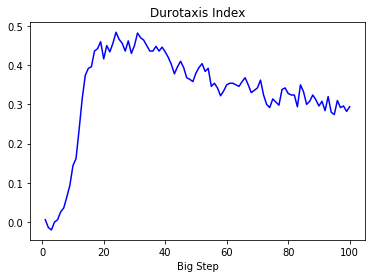

In [5]:
bigsteps = np.linspace(1,int(num_steps/10),int(num_steps/10))

plt.plot(bigsteps, Di.sum(0)/num_walks, 'b-')
plt.title('Durotaxis Index')
plt.xlabel('Big Step');

plt.savefig('Durotaxis index.png')